In [1]:
%matplotlib inline
import numpy as np
import cmath
from scipy.optimize import fsolve, minimize_scalar, minimize, brentq, curve_fit
import matplotlib.pyplot as plt
from matplotlib import cm

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
fparams = {'axes.labelsize': 18,
           'axes.titlesize': 18,
           'font.size': 18,
           'legend.fontsize': 16,
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 16,
           'ytick.labelsize': 16,
           'text.usetex': True,
           'image.cmap': 'seismic'}
           #'figure.autolayout': True}
plt.rcParams.update(fparams)

# Pauli matrices
sx = np.array([[0, 1], [1, 0]], complex)
sy = np.array([[0 , -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]], complex)
s0 = np.array([[1, 0], [0, 1]], complex)

# Physical constants
MU_B = 5.788381 * 1e-2 # Bohr magneton in units of µeV * mT^(-1).
GAP = 151.8 # This is the gap from the zero-field data, in µeV.
TAU = 0.56 # This is the transmission from the zero-field data

# 8x8 Identity matrix
eye = np.eye(8, dtype=complex)

np.seterr(all='raise', divide=None, over=None, under=None, invalid=None)

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

Dimensionless parameters:

$$x = E/\Delta$$

$$y = B/\Delta$$

$$z = \alpha k_F/\Delta$$

In [2]:
def compute_gap(p):
    energy = lambda q, sign: np.sqrt(1 + q**2 + p.y**2 + p.z**2 + 2 * sign * np.sqrt((1 + q**2) * p.y**2 + q**2 * p.z**2))
    gap_plus = minimize_scalar(lambda q: energy(q, 1))
    gap_minus = minimize_scalar(lambda q: energy(q, -1))
    return min(gap_plus.fun, gap_minus.fun)


def x_c(p):
    return np.sqrt(p.z**2 / (p.z**2 + p.y**2))


def z_c(p):
    return np.sqrt(p.y * (1-p.y)) if p.y <1 else 0.


def yc(p, s):
    if p.z < 0.5:
        return 0.5 * (1 + s * np.sqrt(1 - 4 * p.z**2))
    else:
        return 1 - (-1)**s

    
def pole(x, p, sign=-1, tple=False):
    pol = cmath.sqrt(-1 + x**2 + p.y**2 + p.z**2 + 2 * 1j * sign * cmath.sqrt(p.z**2 * (1 - x**2) - x**2 * p.y**2))
    # Makes sure that the pole has positive real part, and positive or negative imaginary part
    # depending on the value of 'sign'
    if not np.sign(pol.imag) == sign:
        pol = np.conj(pol)
    if np.sign(pol.real) < 0:
        pol = -np.conj(pol)
    if tple:
        return (pol.real, pol.imag)
    else:
        return pol

In [3]:
p = SimpleNamespace(z=0)
ys0 = np.linspace(0, 1, 100)
gap0 = []
for y in ys0:
    p.y = y
    gap0.append(compute_gap(p))
ys = np.linspace(0, 2, 200)
gap1 = []
gap2 = []
for y in ys:
    p.y = y
    p.z = 0.25
    gap1.append(compute_gap(p))
    p.z = 0.6
    gap2.append(compute_gap(p))
p.z = 0.25
yc1 = yc(p, -1)
yc2 = yc(p, +1)

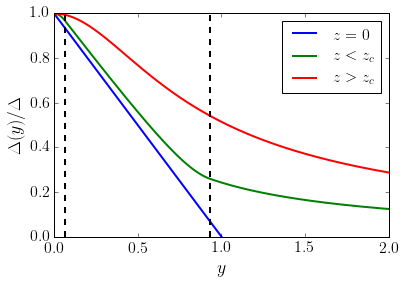

In [4]:
plt.plot(ys0, gap0, lw=2, label=r'$z=0$')
plt.plot(ys, gap1, lw=2, label=r'$z<z_c$')
plt.plot(ys, gap2, lw=2, label=r'$z>z_c$')
#plt.plot(ys, np.sqrt(p.z**2/(ys**2 + p.z**2)))
plt.axvline(yc1, c='k', ls='--', lw=2)
plt.axvline(yc2, c='k', ls='--', lw=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$\Delta(y)/\Delta$')
plt.legend()
plt.savefig("induced_gap.pdf")

## Evolution of the poles in the complex plane

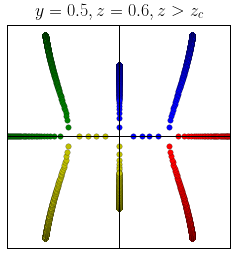

In [5]:
p = SimpleNamespace(y = 0.5, z = 0.6)
xs = np.linspace(0, 2*x_c(p), 500)
q0s = [pole(x, p, sign=-1, tple=True) for x in xs]
q1s = [pole(x, p, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(list(zip(*q0s)))
req1, imq1 = np.array(list(zip(*q1s)))
plt.figure(figsize=(4,4))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='g', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='y', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.yticks([])
plt.xticks([])
plt.title(r'$y=0.5, z=0.6, z>z_c$')
plt.savefig("poles_z>zc.pdf")

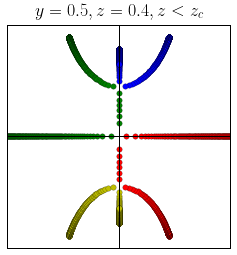

In [6]:
p = SimpleNamespace(y = 0.5, z = 0.4)
xs = np.linspace(0, 2*x_c(p), 500)
q0s = [pole(x, p, sign=-1, tple=True) for x in xs]
q1s = [pole(x, p, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(list(zip(*q0s)))
req1, imq1 = np.array(list(zip(*q1s)))
plt.figure(figsize=(4,4))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='g', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='y', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.yticks([])
plt.xticks([])
plt.title(r'$y=0.5, z=0.4, z<z_c$')
plt.savefig("habby_birthday_dima.pdf")

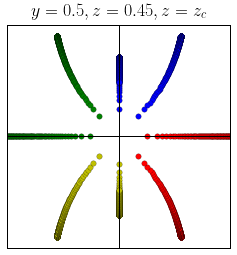

In [7]:
p = SimpleNamespace(y = 0.5, z = 0.5)
xs = np.linspace(0, 2*x_c(p), 500)
q0s = [pole(x, p, sign=-1, tple=True) for x in xs]
q1s = [pole(x, p, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(list(zip(*q0s)))
req1, imq1 = np.array(list(zip(*q1s)))
plt.figure(figsize=(4,4))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='g', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='y', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.yticks([])
plt.xticks([])
plt.title(r'$y=0.5, z=0.45, z=z_c$')
plt.savefig("poles_z=zc.pdf")

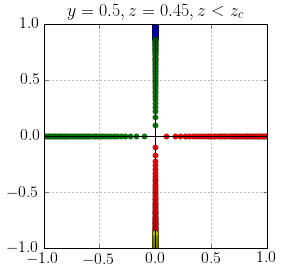

In [8]:
p = SimpleNamespace(y = 0.5, z = 0.)
xs = np.linspace(0, 1, 100)
q0s = [pole(x, p, sign=-1, tple=True) for x in xs]
q1s = [pole(x, p, sign=+1, tple=True) for x in xs]
req0, imq0 = np.array(list(zip(*q0s)))
req1, imq1 = np.array(list(zip(*q1s)))
plt.figure(figsize=(4,4))
plt.grid()
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.scatter(req0, imq0, c='r', s=30, lw=0.2)
plt.scatter(req1, imq1, c='b', s=30, lw=0.2)
plt.scatter(-req0, -imq0, c='g', s=30, lw=0.2)
plt.scatter(-req1, -imq1, c='y', s=30, lw=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title(r'$y=0.5, z=0.45, z<z_c$')

In [64]:
def a(x, p):
    s = np.sqrt(p.y**2 + p.z**2)
    a = x * (1 - x**2 + p.y**2 + p.z**2) * eye
    a -= 2 * x * p.y * np.kron(sx, np.kron(s0, sx))
    a -= 2 * p.y * p.z * np.kron(s0, np.kron(sz, sx)) / s
    a += p.z * (1 - x**2 + p.y**2 + p.z**2) * np.kron(sx, np.kron(sz, s0)) / s
    a += p.y * (1 - x**2 - p.y**2 - p.z**2) * np.kron(sy, np.kron(s0, sy)) / s
    a += (p.y**2 * (1 + x**2 - 2 * p.z**2 - p.y**2) - p.z**2 * (1 - x**2 + p.z**2)) * np.kron(sz, np.kron(s0, sz)) / s
    return a


def c(x, p):
    s = np.sqrt(p.y**2 + p.z**2)
    c = x * eye
    c += p.z * np.kron(sx, np.kron(sz, s0)) / s
    c += p.y * np.kron(sy, np.kron(s0, sy)) / s
    c += s * np.kron(sz, np.kron(s0, sz))
    return c


def g(x, p, q0, q1):
    g = (np.kron(sz, np.kron(sz, s0)))
    g += c(x, p) / (q0 - q1)
    g += a(x, p) /  (q0 * q1 * (q0 - q1))
    return - 0.5 * g


def T(p):
    s = np.sqrt(p.y**2 + p.z**2)
    r = np.sqrt(1 - p.tau) / np.sqrt(p.tau)
    T = eye - 1j * r * np.kron(s0, np.kron(sz, s0))
    T += p.z * r * np.kron(sz, np.kron(sx, sy)) / s
    T += p.y * r * np.kron(s0, np.kron(sy, s0)) / s
    return T


def bound_state_determinant(x, p, remove_asymptote=True, tol=1e-6, warn=False):
    q0 = pole(x, p, sign=-1)
    q1 = pole(x, p, sign=1)
    phiexp = np.cos(0.5 * p.phi) * eye - 1j *  np.sin(0.5 * p.phi) * np.kron(sz, np.kron(s0, s0))
    tfactor = np.dot(phiexp, T(p)) - eye
    gfactor = np.dot(g(x, p, q0, q1), np.kron(sz, np.kron(sz, s0)))
    m = eye - np.dot(gfactor, tfactor)
    mdet = np.linalg.det(m)
    if remove_asymptote:
        mdet *= (q0 * q1 * (q0-q1))**8
    if warn and (mdet.imag > tol):
        print("Imaginary part large at:", x, np.abs(x - gap(p)), mdet.imag, mdet.real, mdet.imag/mdet.real)
        print(Warning("The imaginary part of the determinant is greater than %s" % tol))
    return mdet.real


def func(xs, p):
    D = compute_gap(p)
    domain = lambda x : ((x >= 0) & (x <= D))
    if isinstance(xs, np.ndarray):
        vals = np.array([bound_state_determinant(x, p) if domain(x) else 100 * abs(x) + 100 for x in xs])
        return vals
    else:
        return bound_state_determinant(xs, p)

In [113]:
def find_abs_energies(p):
    
    # Take care of y=0 case
    if p.y == 0:
            Ea = np.sqrt(1 - p.tau * np.sin(p.phi/2)**2)
            return (Ea, Ea)
    
    gap = compute_gap(p)
    xs = np.linspace(0, gap, 1000, endpoint=False)
    sample = func(xs, p)
    sign_changes = np.nonzero(np.diff(np.sign(sample)))[0]
    intervals = [[xs[s - 1], xs[s + 1]] for s in sign_changes]
    Ns = len(sign_changes)
    
    # Discard sign changes in consecutive values of the sample
    # These are assumed to be fluctuations
    if Ns == 2 and np.diff(sign_changes)[0]==1:
        print("Discarding sign change detections: too close to each other.")
        Ns = 0
    
    # Adjust the boundary conditions in case solutions
    # are very close to x=0 or x=gap
    if Ns:
        for s in sign_changes:
            if s == 0:
                print("first sign change very close to x=0")
                intervals[0][0] = 0.
            #if s == (len(xs)-2):
            #    print "second sign change very close to the gap x=0"
            #    print Ns
            #    intervals[1][1] = gap

    if Ns == 0:
        print("No sign changes:", Ns)
        return(gap, gap)
    elif Ns == 1:
        x_1, x_2 = intervals[0]
        try:
            sol1 = brentq(lambda x: func(x, p), x_1, x_2, full_output=False)
        except (Exception, e):
            print("Parameters: ", p.y, p.z, p.tau, p.phi)
            print("Bracketing interval: ", (x_1, x_2))
            print("Function values:", func(x_1, p), func(x_2, p))
            plt.plot(xs, func(xs, p))
            raise e
        return (sol1, gap)
    elif Ns == 2:
        x_1, x_2 = intervals[0]
        x_3, x_4 = intervals[1]
        try:
            sol1 = brentq(lambda x: func(x, p), x_1, x_2, full_output=False)
            sol2 = brentq(lambda x: func(x, p), x_3, x_4, full_output=False)
        except (Exception, e):
            print("Parameters:", p.y, p.z, p.tau, p.phi)
            print("Bracketing interval 1:", (x_1, x_2))
            print("Function values:", func(x_1, p), func(x_2, p))
            print("Bracketing interval 2:", (x_3, x_4))
            print("Function values:", func(x_3, p), func(x_4, p))
            plt.plot(xs, func(xs, p))
            raise e
        return (sol1, sol2)
    else:
        print("Unexpected number of sign changes:", Ns)
        return (np.nan, np.nan)

    
def return_abs_pair_energy(p):
    levels = find_abs_energies(p)
    return np.average(levels)


def fit_abs_pair_energy(B, z, gfactor, tau, phi, gap):
    y = 0.5 * gfactor * MU_B * B / gap
    p = SimpleNamespace(y=y, z=z, tau=tau, phi=phi)
    if z <= 0:
        return 1e5
    if gfactor <=2:
        return 1e5
    else:
        energy = return_abs_pair_energy(p)
        return energy

vfit_abs_pair_energy = np.vectorize(fit_abs_pair_energy, otypes=[np.float],
                                    excluded=['z', 'gfactor', 'tau', 'phi', 'gap'])

## Splitting at finite $z$, perfect transmission, and $\phi=\pi$

In [66]:
p = SimpleNamespace(y=0.1, z=0.3, tau=0.75, phi=np.pi)
ys = np.linspace(0., 1.5, 150)
energies = []
gaps = []
for y in ys:
    p.y = y
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(compute_gap(p))

first sign change very close to x=0


In [67]:
ens1, ens2 = np.asarray(list(zip(*energies)))

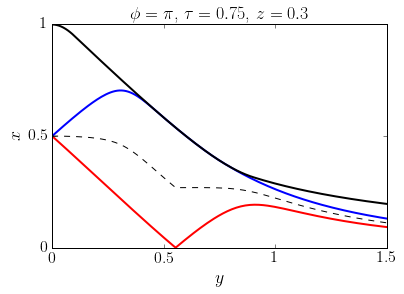

In [68]:
plt.plot(ys, ens1, c='r', lw=2)
plt.plot(ys, ens2, c='b', lw=2)
plt.plot(ys, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(ys, gaps, c='k', lw=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$x$')
plt.xlim([0., 1.5])
plt.yticks([0, 0.5, 1], [r'$0$', r'$0.5$', r'$1$'])
plt.xticks([0, 0.5, 1, 1.5], [r'$0$', r'$0.5$', r'$1$', r'$1.5$'])
plt.title(r'$\phi=\pi$, $\tau=0.75$, $z=0.3$')
plt.savefig("spectrum_weak_so.pdf")
#plt.plot(ys, [gap(y, p.z) for y in ys], c='k', lw=2)

In [142]:
p = SimpleNamespace(y=0.2, z=0.6, tau=0.75, phi=np.pi)
ys = np.linspace(0., 1.5, 150)
energies = []
gaps = []
for y in ys:
    p.y = y
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(list(zip(*energies)))

first sign change very close to x=0


In [204]:
0.5 * 12 * MU_B * 390

135.4481154

In [151]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

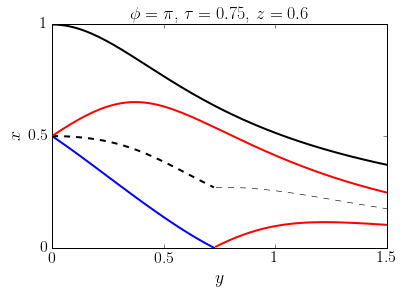

In [202]:
plt.plot(ys[:73], ens1[:73], c='b', lw=2)
plt.plot(ys[73:], ens1[73:], c='r', lw=2)
plt.plot(ys[:73], (ens1[:73]+ens2[:73])/2, c='k', ls='--', lw=2)
plt.plot(ys[73:], (ens1[73:]+ens2[73:])/2, c='k', ls='--', lw=0.6)
plt.plot(ys, ens2, c='r', lw=2)
plt.plot(ys, gaps, c='k', lw=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$x$')
plt.xlim([0., 1.5])
plt.yticks([0, 0.5, 1], [r'$0$', r'$0.5$', r'$1$'])
plt.xticks([0, 0.5, 1, 1.5], [r'$0$', r'$0.5$', r'$1$', r'$1.5$'])
plt.title(r'$\phi=\pi$, $\tau=0.75$, $z=0.6$')
plt.savefig("spectrum_strong_so_different_colors.pdf")
#plt.plot(ys, [gap(y, p.z) for y in ys], c='k', lw=2)

## Splitting at zero $z$, finite transmission, and $\phi=\pi$

In [72]:
p = SimpleNamespace(y=0.2, z=1e-8, tau=0.75, phi=np.pi)
ys = np.linspace(0., 1, 100)
energies = []
gaps = []
for y in ys:
    p.y = y
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(list(zip(*energies)))

No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0


/Users/bvh/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


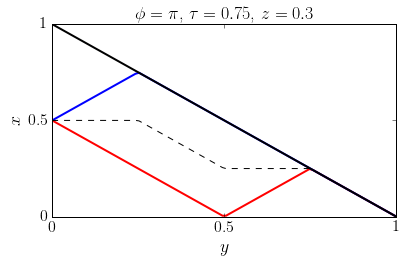

In [73]:
plt.plot(ys, ens1, c='r', lw=2)
plt.plot(ys, ens2, c='b', lw=2)
plt.plot(ys, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(ys, gaps, c='k', lw=2)
plt.xlabel(r'$y$')
plt.ylabel(r'$x$')
plt.xlim([0., 1.])
plt.yticks([0, 0.5, 1], [r'$0$', r'$0.5$', r'$1$'])
plt.xticks([0, 0.5, 1], [r'$0$', r'$0.5$', r'$1$'])
plt.title(r'$\phi=\pi$, $\tau=0.75$, $z=0.3$')
plt.savefig("spectrum_no_so.pdf")
#plt.plot(ys, [gap(y, p.z) for y in ys], c='k', lw=2)

## Fit to experimental data

In [20]:
minima = [(0, 1.01809e-4),(50, 9.98742e-5),(75, 9.58812e-5),(100,9.2654e-5),
          (150,8.38036e-5),(200,7.27897e-5),(300,4.26e-5)]
Es1 = np.array([132.5,127.5,120.5,116,109,91.5,60.5])
Es2 = np.array([112,108,103.2,101,91.2,78.9,52])
Bs, Es = np.asarray(list(zip(*minima)))
Es *= 1e6
Es /= GAP
Es1 /= GAP
Es2 /= GAP

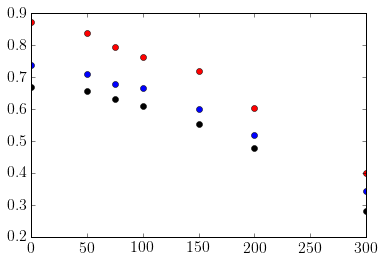

In [25]:
plt.plot(Bs, Es, 'o', c='k')
plt.plot(Bs, Es1, 'o', c='r')
plt.plot(Bs, Es2, 'o', c='b')

In [ ]:
popt, pcov = curve_fit(lambda x, z, gf: vfit_abs_pair_energy(x, z, gf, TAU, np.pi, GAP),
                       Bs[1:], Es[1:], p0=[0.55, 10])
popt, pcov

In [87]:
p = SimpleNamespace(z=popt[0], gfactor=popt[1], tau=TAU, phi=np.pi)
fields = np.linspace(0., 500, 100)
spectra = []
gaps = []
for phi in (np.pi/2, 3*np.pi/4, np.pi):
    p.phi = phi
    energies = []
    for B in fields:
        p.y = 0.5 * p.gfactor * MU_B * B / GAP
        sol = find_abs_energies(p)
        energies.append(sol)
        if phi == np.pi:
            gaps.append(compute_gap(p))
    spectra.append(energies)
#ens1, ens2 = np.asarray(list(zip(*energies)))

In [88]:
ens1, ens2 = np.asarray(list(zip(*spectra[0])))
ens3, ens4 = np.asarray(list(zip(*spectra[1])))
ens5, ens6 = np.asarray(list(zip(*spectra[2])))

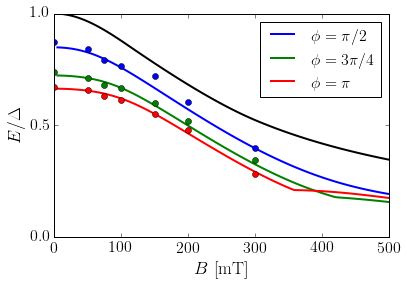

In [106]:
plt.plot(fields, gaps[:100], c='k', lw=2)
plt.plot(fields[1:], (ens1[1:]+ens2[1:])/2, lw=2, label=r'$\phi=\pi/2$')
plt.plot(fields[1:], (ens3[1:]+ens4[1:])/2, lw=2, label=r'$\phi=3\pi/4$')
plt.plot(fields[1:], (ens5[1:]+ens6[1:])/2, lw=2, label=r'$\phi=\pi$')
plt.plot(Bs, Es, 'o', c='r')
plt.plot(Bs, Es1, 'o', c='b')
plt.plot(Bs, Es2, 'o', c='g')
plt.yticks([0, 0.5, 1])
plt.legend()
plt.ylabel(r'$E/\Delta$')
plt.xlabel(r'$B$ [mT]')
plt.savefig("absorption_frequency_at_different_phases.pdf")

In [115]:
abs_en = lambda phi, tau: np.sqrt(1 - tau * np.sin(phi/2)**2)

In [117]:
abs_en(np.pi, TAU), abs_en(3*np.pi/4, TAU), abs_en(np.pi/2, TAU) 

(0.66332495807107994, 0.7225026652322929, 0.84852813742385702)

([<matplotlib.axis.YTick at 0x111bce438>,
 <a list of 4 Text yticklabel objects>)

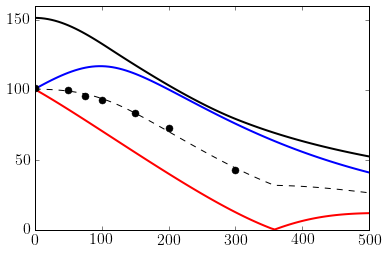

In [50]:
plt.plot(fields, GAP * ens5, c='r', lw=2)
plt.plot(fields, GAP * ens6, c='b', lw=2)
plt.plot(fields, GAP * (ens5 + ens6)/2, c='k', ls='--', lw=1)
plt.plot(fields, GAP * np.asarray(gaps), c='k', lw=2)
plt.plot(Bs, GAP * Es, 'o', c='k', markersize=7)
plt.yticks([0, 50, 100, 150])
#plt.savefig("fit_fig_4b_new_ticks_yaxis.pdf")

## Trying to fit the orbital effect

In [122]:
def fit_orbital(B, b, tau, phi):
    return (1 - B**2/b**2) * np.sqrt(1 - tau * np.sin(phi/2)**2)

In [124]:
popt_orb, pcov_orb = curve_fit(lambda x, b: fit_orbital(x, b, TAU, np.pi),
                               Bs[1:], Es[1:], p0=[1.])
popt_orb

array([ 390.39991161])

(0, 1)

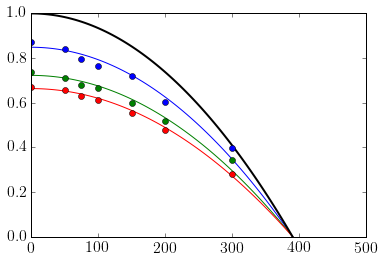

In [208]:
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2))
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4))
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi))
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2), c='k', lw=2)
plt.plot(Bs, Es, 'o', c='r')
plt.plot(Bs, Es2, 'o', c='g')
plt.plot(Bs, Es1, 'o', c='b')
plt.ylim([0, 1])

### Including a g-factor = 12

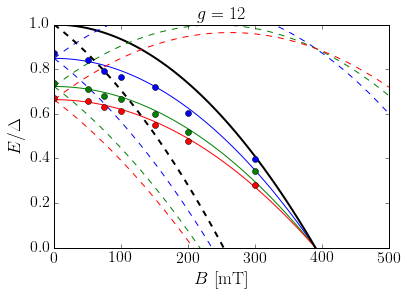

In [225]:
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2), c='b')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4), c='g')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi), c='r')
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2), c='k', lw=2)
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2) - 0.5 * fields * MU_B * 12 / GAP, c='b', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4) - 0.5 * fields * MU_B * 12 / GAP, c='g', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi) - 0.5 * fields * MU_B * 12 / GAP, c='r', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2) + 0.5 * fields * MU_B * 12 / GAP, c='b', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4) + 0.5 * fields * MU_B * 12 / GAP, c='g', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi) + 0.5 * fields * MU_B * 12 / GAP, c='r', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2) - 0.5 * fields * MU_B * 12 / GAP, c='k', lw=2, ls='--')
plt.plot(Bs, Es, 'o', c='r')
plt.plot(Bs, Es2, 'o', c='g')
plt.plot(Bs, Es1, 'o', c='b')
plt.ylim([0, 1])
plt.title(r"$g=12$")
plt.ylabel(r'$E/\Delta$')
plt.xlabel(r'$B$ [mT]')
plt.savefig("absorption_frequency_orbital_and_zeeman.pdf")

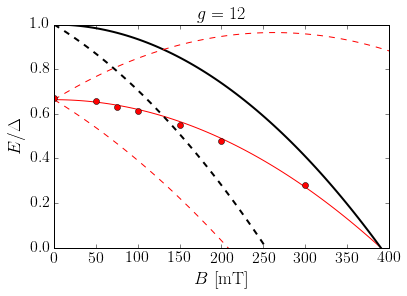

In [230]:
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi), c='r')
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2), c='k', lw=2)
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi) - 0.5 * fields * MU_B * 12 / GAP, c='r', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi) + 0.5 * fields * MU_B * 12 / GAP, c='r', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2) - 0.5 * fields * MU_B * 12 / GAP, c='k', lw=2, ls='--')
plt.plot(Bs, Es, 'o', c='r')
#plt.plot(Bs, Es2, 'o', c='g')
#plt.plot(Bs, Es1, 'o', c='b')
plt.ylim([0, 1])
plt.xlim([0,400])
plt.title(r"$g=12$")
plt.ylabel(r'$E/\Delta$')
plt.xlabel(r'$B$ [mT]')
plt.savefig("absorption_frequency_orbital_and_zeeman_only_one_curve.pdf")

(0, 1)

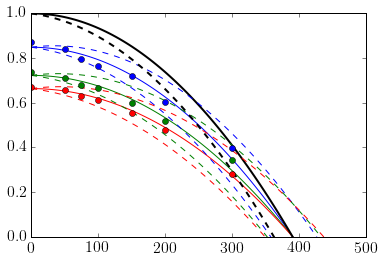

In [222]:
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2), c='b')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4), c='g')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi), c='r')
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2), c='k', lw=2)
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2) - 0.5 * fields * MU_B * 2 / GAP, c='b', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4) - 0.5 * fields * MU_B * 2 / GAP, c='g', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi) - 0.5 * fields * MU_B * 2 / GAP, c='r', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi/2) + 0.5 * fields * MU_B * 2 / GAP, c='b', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, 3*np.pi/4) + 0.5 * fields * MU_B * 2 / GAP, c='g', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, TAU, np.pi) + 0.5 * fields * MU_B * 2 / GAP, c='r', ls='--')
plt.plot(fields, fit_orbital(fields, popt_orb, 0., np.pi/2) - 0.5 * fields * MU_B * 2 / GAP, c='k', lw=2, ls='--')
plt.plot(Bs, Es, 'o', c='r')
plt.plot(Bs, Es2, 'o', c='g')
plt.plot(Bs, Es1, 'o', c='b')
plt.ylim([0, 1])

## Increasing spin-orbit with respect to the best value from the fit

In [ ]:
popt2, pcov2 = curve_fit(lambda x, z, gf: vfit_abs_pair_energy(x, z, gf, TAU, np.pi, GAP),
                       Bs[1:], Es[1:], p0=[1.6, 40])
popt2, pcov2

In [ ]:
p = SimpleNamespace(z=1.1, gfactor=30, tau=TAU, phi=np.pi)
fields = np.linspace(0., 500, 80)
energies = []
gaps = []
for B in fields:
    p.y = 0.5 * p.gfactor * MU_B * B / GAP
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(zip(*energies))

In [ ]:
plt.plot(fields, ens1, c='r', lw=2)
plt.plot(fields, ens2, c='b', lw=2)
plt.plot(fields, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(fields, gaps, c='k', lw=2)
plt.plot(Bs, Es, 'o', c='k', markersize=7)
plt.xlabel(r'$B$ [mT]')
plt.ylabel(r'$E/\Delta$')
#plt.savefig('fit_higher_so.pdf')

Some numerical experiment. This is the range of $z=\alpha k_F/\Delta$ such that a Fermi-level crossing happens between 300 mT and 500 mT, at a given $g$-factor. Note: I have not done a systematic search of the interval limits, these are just estimates based on a few samples.

$g = 12$ : $z \sim 0.25-0.7$

$g = 20$ : $z \sim 0.7-0.9$

$g = 30$ : $z \sim 0.85-1$

In the last two lines, the right limit of the $z$ interval basically coincides with the limit at which no Fermi-level crossing appears anymore. If one enforces the constraint that a Fermi-level crossing appears, then the agreement with the data worsens by increasing $g$.

## Phase dependence of the ABS levels for best fit parameters, at $B=200$ mT

In [ ]:
p = SimpleNamespace(z=popt[0], B=100, gfactor=popt[1], tau=TAU)
p.y = 0.5 * p.gfactor * MU_B * p.B / GAP
phases = np.linspace(1e-4, 2*np.pi-1e-4, 100)
p.gap = compute_gap(p)
energies = []
for phi in phases:
    p.phi = phi
    sol = find_abs_energies(p)
    energies.append(sol)
abs_down, abs_up = np.asarray(zip(*energies))

In [ ]:
# Fixes the value at phi=0, 2π, by continuity.
# At phi =0, 2π, numerics fail to find zeros due to a very shallow function
abs_down[0] = (abs_down[1] + abs_up[1])/2
abs_up[0] = (abs_down[1] + abs_up[1])/2
abs_down[-1] = (abs_down[1] + abs_up[1])/2
abs_up[-1] = (abs_down[1] + abs_up[1])/2

In [ ]:
plt.plot(phases, abs_down, c='r', lw=2)
plt.plot(phases, abs_up, c='b', lw=2)
plt.plot(phases, (abs_up+abs_down)/2, c='k', lw=1, ls='--')
plt.axhline(p.gap, c='k', lw=2)
plt.yticks([0, p.gap/2, p.gap], [r'$0$', r'', r'$\Delta(B)$'])
plt.xticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
plt.xlabel(r'$\varphi$')
plt.ylabel(r'$E_\pm(\varphi)$', labelpad=-18)
plt.title(r'$B=%s$ mT' % p.B)
plt.ylim(0, p.gap+0.05)
plt.xlim(0, 2*np.pi)
plt.savefig("dispersion_ABS_at_100_mT.pdf")

In [ ]:
p.phi = 6.35644981e-02

In [ ]:
sol = find_abs_energies(p)

In [ ]:
p.gap

In [ ]:
rng = np.linspace(0.855, 0.865, 100)
plt.plot(rng, func(rng, p))
plt.axvline(sol[0])
plt.axvline(sol[1])

## Non-monotonicity of energy difference between contiuum and ABS: dependence on $\tau$.

In [ ]:
p = SimpleNamespace(z=0.6, phi=np.pi)
taus=(0.25, 0.50, 0.75, 0.99)
ys = np.linspace(0., 2, 100)
list_of_energies = []
list_of_gaps = []
for tau in taus:
    p.tau = tau
    gaps = []
    energies = []
    for y in ys:
        p.y = y
        sol = find_abs_energies(p)
        energies.append(sol)
        gaps.append(compute_gap(p))
    list_of_energies.append(energies)
    list_of_gaps.append(gaps)

In [ ]:
ncol = len(taus)
cmap = cm.hot
col_ind = np.linspace(0, 150, ncol)
col_array = cmap(col_ind.astype(int))
plt.figure()
for n, (tau, levels, gaps, col) in enumerate(zip(taus, list_of_energies, list_of_gaps, col_array)):
    ens1, ens2 = np.asarray(zip(*levels))
    plt.plot(ys, gaps-ens2, lw = 2, c=col, label = r'$\tau=%s$' % tau)
    plt.legend()
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])
    plt.ylabel(r'$E_\textrm{gap}-E_+$')
    plt.xlabel(r'$y$')
    plt.title(r'$z=%s\,,\,\phi=\pi$' % p.z)
plt.savefig("level_repulsion_varying_transmission.pdf")
plt.show()

In [ ]:
plt.figure()
for n, (tau, levels, gaps) in enumerate(zip(taus, list_of_energies, list_of_gaps)):
    ens1, ens2 = np.asarray(zip(*levels))
    plt.plot(ys, gaps-ens1, lw = 2, label = r'$\tau=%s$' % tau)
    plt.legend()
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])
    plt.ylabel(r'$E_\textrm{gap}-E_-$')
    plt.xlabel(r'$y$')
    plt.title(r'$z=%s\,,\,\phi=\pi$' % p.z)
plt.show()

In [ ]:
plt.figure()
for n, (tau, levels, gaps) in enumerate(zip(taus, list_of_energies, list_of_gaps)):
    ens1, ens2 = np.asarray(zip(*levels))
    plt.plot(ys, ens2-ens1, lw=2,  label = r'$\tau=%s$' % tau)
    plt.legend()
    plt.legend()
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])
    plt.ylabel(r'$E_+-E_-$')
    plt.xlabel(r'$y$')
    plt.title(r'$z=%s\,,\,\phi=\pi$' % p.z)
plt.show()

## Non-monotonicity of the energy splitting between continuum and ABS: dependence on $z$

In [ ]:
%%capture
p = SimpleNamespace(z=0.6, tau=0.95, phi=np.pi)
zs = (0.01, 0.2, 0.4, 0.6)
ys = np.linspace(0., 2, 100)
list_of_energies2 = []
list_of_gaps2 = []
for z in zs:
    p.z = z
    gaps = []
    energies = []
    for y in ys:
        p.y = y
        sol = find_abs_energies(p)
        energies.append(sol)
        gaps.append(compute_gap(p))
    list_of_energies2.append(energies)
    list_of_gaps2.append(gaps)

In [ ]:
ncol = len(zs)
cmap = cm.hot
col_ind = np.linspace(0, 150, ncol)
col_array = cmap(col_ind.astype(int))
plt.figure()
for n, (z, levels, gaps, col) in enumerate(zip(zs, list_of_energies2, list_of_gaps2, col_array)):
    ens1, ens2 = np.asarray(zip(*levels))
    plt.plot(ys, gaps-ens2, lw = 2, c=col, label = r'$z=%s$' % z)
    plt.plot(ys, gaps, ls='--', c=col)
    plt.legend()
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])
    plt.ylabel(r'$E_\textrm{gap}-E_+$')
    plt.xlabel(r'$y$')
    plt.title(r'$\tau=%s\,,\,\phi=\pi$' % p.tau)
plt.savefig("level_replusion_varying_z.pdf")
plt.show()

In [ ]:
p.z = zs[1]
ens1, ens2 = np.asarray(zip(*list_of_energies2[1]))
gaps = list_of_gaps2[1]
plt.figure()
plt.plot(ys, gaps, c='k', lw=2, label=r'$E_\textrm{gap}$')
plt.plot(ys, ens2, c='b', lw=2, label=r'$E_+$')
plt.plot(ys, gaps-ens2, c='k', ls='--', lw=1, label=r'$E_\textrm{gap}-E_+$')
plt.xlabel(r'$y$')
plt.yticks([0, 0.5, 1])
plt.title(r'$z=%s\,,\,\phi=\pi$' % zs[1])
plt.ylabel(r'$E$')
plt.legend()
plt.axvline(yc(p, +1), c='r', ls='--')
plt.savefig("level_repulsion_example_at_small_z.pdf")

## Splitting of ABS levels at large $y$, as a function of $\tau$.

In [ ]:
p = SimpleNamespace(y=6, z=0.6, phi=np.pi)
taus = np.linspace(1e-4, 1 - 1e-4, 200)
splittings = []
for tau in taus:
    p.tau = tau
    en1, en2 = find_abs_energies(p)
    splittings.append(en2 - en1)

In [ ]:
12 * MU_B * 300 / 2

In [ ]:
plt.plot(taus, splittings, c='k', lw=2)
plt.title(r'$y=%s,\; z=%s$' % (p.y, p.z))
plt.yticks([0, 0.01])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$E_+-E_-$')
plt.savefig("ABS_splitting_at_large_y.pdf")

## Fit for dev_1_103_117.txt

In [ ]:
#GAP_103 = 167
#TAU_103 = 0.67
#minima_103= [(0,97),(1,95),(4,97),(10,96),(20,97),(40,94),(100,89),
# (125,87),(150,80),(160,78),(175,76),(185,74),(200,69),(225,65),(240,59),(250,61),(200,71),(225,67),(250,65),]
#Bs_103, Es_103 = np.asarray(zip(*minima_103))
#Es /= GAP_103
#popt_103, pcov_103 = curve_fit(lambda x, z, gf: vfit_abs_pair_energy(x, z, gf, TAU_103, np.pi, GAP_103),
#                       Bs_103, Es_103, p0=[1.5, 12])
#popt_103, pcov_103

In [ ]:
#plt.plot(Bs_103, Es_103,'.')

## Fit for dev_2_166.txt

In [15]:
GAP_166 =130
TAU_166 =0.57
minima_166 = [(1,84),(28,86),(69,84),(109,78),(133,76),(178,71),(191,69),(213,63)]
Bs_166, Es_166 = np.asarray(zip(*minima_166))
Es /= GAP_166
popt_166, pcov_166 = curve_fit(lambda x, z, gf: vfit_abs_pair_energy(x, z, gf, TAU_166, np.pi, GAP_166),
                       Bs_166, Es_166, p0=[1.5, 12])
popt_166, pcov_166

Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
Discarding sign change detections: too close to each other.
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign changes: 0
No sign

(array([ 2.38617781,  2.00356668]),
 array([[  1.17094002e+16,   9.41972822e+15],
        [  9.41972822e+15,   7.57778501e+15]]))

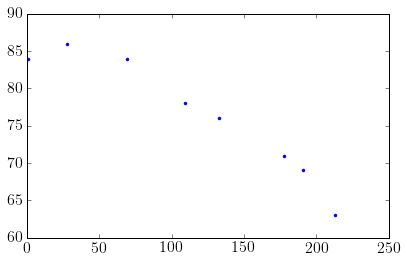

In [16]:
plt.plot(Bs_166, Es_166,'.')

In [ ]:
p = SimpleNamespace(z=popt_166[0], gfactor=popt_166[1], tau=TAU_166, phi=np.pi)
fields = np.linspace(0., 300, 80)
energies = []
gaps = []
for B in fields:
    p.y = 0.5 * p.gfactor * MU_B * B / GAP_166
    sol = find_abs_energies(p)
    energies.append(sol)
    gaps.append(compute_gap(p))
ens1, ens2 = np.asarray(zip(*energies))

In [ ]:
plt.plot(fields, ens1, c='r', lw=2)
plt.plot(fields, ens2, c='b', lw=2)
plt.plot(fields, (ens1 + ens2)/2, c='k', ls='--', lw=1)
plt.plot(fields, gaps, c='k', lw=2)
#plt.plot(Bs, Es, 'o', c='k', markersize=7)

## Fit for dev_2_162.txt

In [17]:
GAP_162 = 123
TAU_162 = 0.73
minima_162 = [(13,64),(26,65),(42,66),(54,65),(67,64),(91,64),(108,63),(118,62),(145,61),(158,58),(171,58),(198,56),
              (210,52),(224,52),(251,49)]
Es /= GAP_162
popt_162, pcov_162 = curve_fit(lambda x, z, gf: vfit_abs_pair_energy(x, z, gf, TAU_162, np.pi, GAP_162),
                       Bs_162, Es_162, p0=[1.5, 12])
popt_162, pcov_162

NameError: name 'Bs_162' is not defined

## Fit for dev_2_156.txt

In [ ]:
GAP_156 = 147
TAU_156 = 0.52
minima_156 = [(8,104),(22,102),(40,103),(64,96),(103,95),(120,93),(134,89),(146,89),(171,83),(202,77),(215,74),
              (242,62),(263,56)]
Es /= GAP_156
popt_156, pcov_156 = curve_fit(lambda x, z, gf: vfit_abs_pair_energy(x, z, gf, TAU_156, np.pi, GAP_156),
                       Bs_156, Es_156, p0=[1.5, 12])
popt_156, pcov_156